# Снятие омонимии

In [3]:
#! pip install conllu

In [4]:
# !pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git

In [92]:
from io import open
from tqdm import tqdm
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter
from conllu import parse_incr  # https://pypi.org/project/conllu/
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

Берём [UD SyntagRus](https://github.com/UniversalDependencies/UD_Russian-SynTagRus):

In [7]:
# train - часть a (надеемся, что хватит материала для обучения)
# !wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu

In [9]:
# test
# !wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu

Будем парсить conllu. Спасибо, parse_incr().

In [60]:
with open("ru_syntagrus-ud-train-a.conllu", "r", encoding="utf-8") as f:
    i = 0
    for t in parse_incr(f):
        print(t)
        print(len(t))
        print(t[1], t[1]['lemma'], t[1]['upos'])  # слово, лемма, pos
        i += 1
        if i > 1:
            break


TokenList<Анкета, ., metadata={sent_id: "2003Anketa.xml_1", text: "Анкета."}>
2
. . PUNCT
TokenList<Начальник, областного, управления, связи, Семен, Еремеевич, был, человек, простой, ,, приходил, на, работу, всегда, вовремя, ,, здоровался, с, секретаршей, за, руку, и, иногда, даже, писал, в, стенгазету, заметки, под, псевдонимом, ", Муха, ", ., metadata={sent_id: "2003Anketa.xml_2", text: "Начальник областного управления связи Семен Еремеевич был человек простой, приходил на работу всегда вовремя, здоровался с секретаршей за руку и иногда даже писал в стенгазету заметки под псевдонимом "Муха"."}>
34
областного областной ADJ


In [67]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#features
# берёт предложение и номер слова, для которого делает словарь фичей
def word2features(sent, i):
    word = sent[i]['form']

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    if i > 0:
        prev_word = sent[i-1]['lemma']
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next_word = sent[i+1]['lemma']
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True

    return features

In [68]:
# делает список crf фичей для всех слов одного предложения
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [69]:
# достаёт список pos из предложения
def sent2labels(sent):
    return [word['upos'] for word in sent]

In [106]:
# объединение предыдущих двух
def get_features_labels(filename):
    X = []
    y = []
    with open(filename, "r", encoding="utf-8") as f:
        for s in tqdm(parse_incr(f)):
            X.append(sent2features(s))
            y.append(sent2labels(s))

    return X, y

Достаём фичи и pos из train и test

In [119]:
X_train, y_train = get_features_labels("ru_syntagrus-ud-train-a.conllu")

24516it [00:28, 855.43it/s] 


In [31]:
X_test, y_test = get_features_labels("ru_syntagrus-ud-test.conllu")

8800it [00:08, 983.94it/s] 


In [84]:
X_train[0][0]

{'bias': 1.0,
 'word.lower()': 'анкета',
 'word[-3:]': 'ета',
 'word[-2:]': 'та',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'BOS': True,
 '+1:word.lower()': '.',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False}

In [85]:
y_train[0][0]

'NOUN'

Вот такие теги в test

In [86]:
allposlist = sum(y_train, [])

In [78]:
Counter(allposlist)

Counter({'NOUN': 103538,
         'PUNCT': 77972,
         'ADJ': 43357,
         'PROPN': 14855,
         'AUX': 3537,
         'VERB': 47731,
         'ADP': 39344,
         'ADV': 22733,
         'CCONJ': 15168,
         'PART': 13556,
         'PRON': 18733,
         'DET': 10781,
         'SCONJ': 8057,
         'NUM': 5640,
         '_': 521,
         'INTJ': 50,
         'X': 189,
         'SYM': 420})

### Обучаем

In [87]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)

crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|█| 24516/24516 [00:11<00:00, 2094.12it/s



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 208234
Seconds required: 2.532

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=2.19  loss=1082582.33 active=205848 feature_norm=1.00
Iter 2   time=1.13  loss=877474.30 active=202952 feature_norm=8.53
Iter 3   time=0.94  loss=688672.29 active=199032 feature_norm=9.01
Iter 4   time=1.11  loss=621719.77 active=203848 feature_norm=9.27
Iter 5   time=0.88  loss=541354.58 active=203604 feature_norm=10.97
Iter 6   time=0.82  loss=448022.20 active=203301 feature_norm=15.18
Iter 7   time=0.92  loss=376281.58 active=203020 feature_norm=21.84
Iter 8   time=0.86  loss=320526.35 active=203018 feature_norm=26.30
Iter 9   time=0.82  loss=285730.63 active=202955 feature_

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100, verbose=True)

### Проверим успешность

In [90]:
y_pred = crf.predict(X_test)

In [93]:
labels = list(crf.classes_)

In [98]:
print(metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3))

              precision    recall  f1-score   support

        NOUN      0.979     0.947     0.963     36568
       PUNCT      1.000     1.000     1.000     29463
         ADJ      0.900     0.939     0.919     14471
       PROPN      0.705     0.967     0.816      5883
         AUX      0.939     0.922     0.931      1518
        VERB      0.962     0.928     0.945     18146
         ADP      0.998     0.995     0.996     15062
         ADV      0.927     0.901     0.914      8085
       CCONJ      0.958     0.963     0.961      5736
        PART      0.950     0.879     0.913      4921
        PRON      0.958     0.946     0.952      8015
         DET      0.941     0.877     0.908      4094
       SCONJ      0.897     0.948     0.922      2992
         NUM      0.953     0.920     0.937      2528
           _      1.000     1.000     1.000       271
        INTJ      1.000     0.130     0.231        23
           X      0.947     0.375     0.537        48
         SYM      1.000    

f1 weighted = 0.954. Мне нравится

### Что с чем больше путается?

In [100]:
cm = confusion_matrix(sum(y_test, []), sum(y_pred, []), labels=crf.classes_)

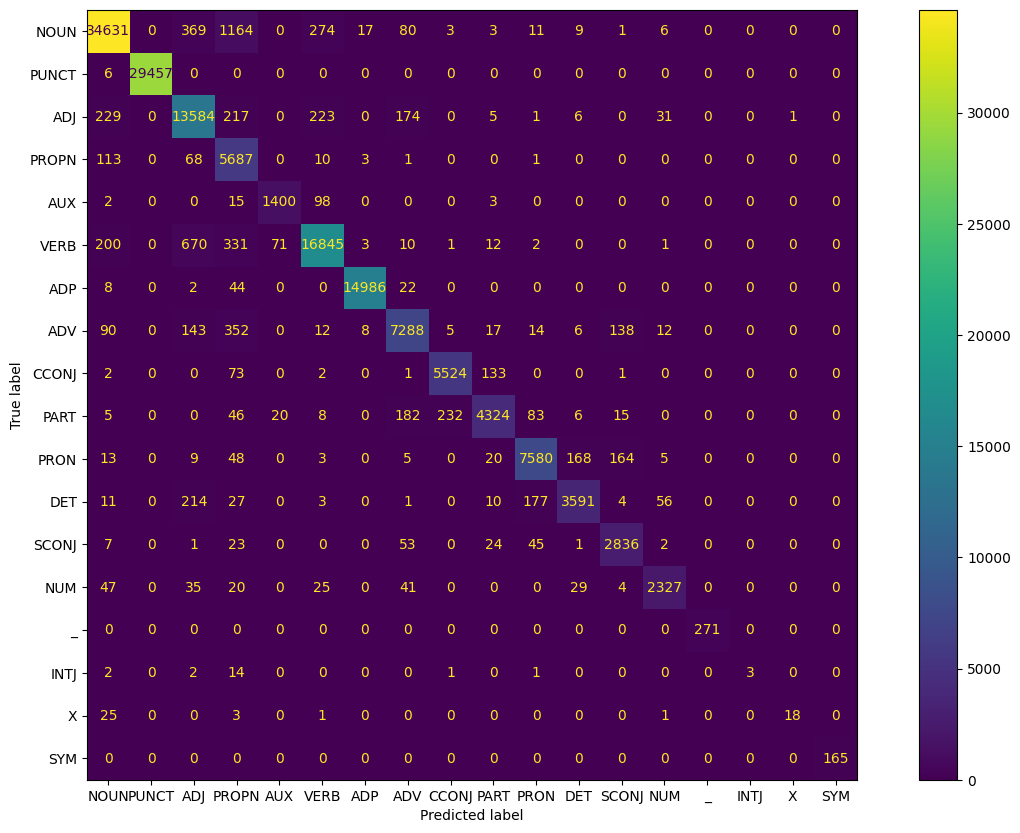

In [105]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=crf.classes_)
fig, ax = plt.subplots(figsize=(16,10))
disp.plot(ax=ax)

NOUN путаются с PROPN - отлично, можно объединить два класса в один и качество будет лучше. И те, и другие - существительные

Глаголы и существительные путаются с прилагательными.

PART и CCONJ, DET и PRON я тоже путаю

Можно было бы давать возможные разборы слова от pymorphy в помощь... (найти лучшие параметры, в фичах смотреть на большее окно)

Но я пока посто попрбую добавить вторую из 4х частей тренировочных данных.

In [108]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-b.conllu

--2023-06-20 19:07:01--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-b.conllu
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 42819832 (41M) [text/plain]
Сохранение в: «ru_syntagrus-ud-train-b.conllu»

ru_syntagrus-ud-tra 100%[===================>]  40,84M  2,95MB/s    за 18s     

2023-06-20 19:07:22 (2,22 MB/s) - «ru_syntagrus-ud-train-b.conllu» сохранён [42819832/42819832]



In [109]:
X_train2, y_train2 = get_features_labels("ru_syntagrus-ud-train-b.conllu")

24298it [00:21, 1111.91it/s]


In [120]:
len(X_train), len(y_train)

(24516, 24516)

In [121]:
X_train += X_train2
y_train += y_train2

In [122]:
len(X_train), len(y_train)

(48814, 48814)

In [123]:
crf2 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)

crf2.fit(X_train, y_train)

loading training data to CRFsuite: 100%|█| 48814/48814 [00:26<00:00, 1854.22it/s



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 326641
Seconds required: 5.597

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=4.26  loss=2212618.80 active=323009 feature_norm=1.00
Iter 2   time=2.04  loss=1792047.19 active=318319 feature_norm=8.55
Iter 3   time=1.91  loss=1406131.61 active=311694 feature_norm=9.00
Iter 4   time=1.92  loss=1270269.24 active=319272 feature_norm=9.25
Iter 5   time=1.95  loss=1108319.19 active=319207 feature_norm=10.88
Iter 6   time=1.73  loss=919602.12 active=318641 feature_norm=15.14
Iter 7   time=1.98  loss=772319.22 active=318349 feature_norm=21.51
Iter 8   time=1.97  loss=665668.76 active=318936 feature_norm=25.62
Iter 9   time=1.83  loss=583824.59 active=318252 feat

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100, verbose=True)

In [124]:
y_pred2 = crf.predict(X_test)

In [125]:
labels = list(crf2.classes_)

In [126]:
print(metrics.flat_classification_report(y_test, y_pred2, labels=labels, digits=3))

              precision    recall  f1-score   support

        NOUN      0.979     0.947     0.963     36568
       PUNCT      1.000     1.000     1.000     29463
         ADJ      0.900     0.939     0.919     14471
       PROPN      0.705     0.967     0.816      5883
         AUX      0.939     0.922     0.931      1518
        VERB      0.962     0.928     0.945     18146
         ADP      0.998     0.995     0.996     15062
         ADV      0.927     0.901     0.914      8085
       CCONJ      0.958     0.963     0.961      5736
        PART      0.950     0.879     0.913      4921
        PRON      0.958     0.946     0.952      8015
         DET      0.941     0.877     0.908      4094
       SCONJ      0.897     0.948     0.922      2992
         NUM      0.953     0.920     0.937      2528
           _      1.000     1.000     1.000       271
        INTJ      1.000     0.130     0.231        23
           X      0.947     0.375     0.537        48
         SYM      1.000    

Ну вот, ничего не изменилось... Видимо, правда для улучшения надо фичи и параметры подбирать.